In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler  # Normalizing data
from sklearn.decomposition import PCA  # Principal component
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from functions.distance import get_distance, norm_features, split_random

Columns in apartments_and_building files:
"building_id","id","id1","seller","price","area_total","area_kitchen","area_living","floor","rooms","layout","ceiling","bathrooms_shared","bathrooms_private","windows_court","windows_street","balconies","loggias","condition","phones","new","latitude","longitude","district","street","address","constructed","material","stories","elevator_without","elevator_passenger","elevator_service","parking","garbage_chute","heating"

In [2]:
X_Train = pd.read_csv("../data/apartments_and_building_train.csv")
X_Test = pd.read_csv("../data/apartments_and_building_test.csv")

In [3]:
X_Train.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,18450,-9,11300000.0,73.8,153116.531165,9.0,47.0,1,3,...,4АК3,-9,-9,5,-9,-9,-9,-9,-9,-9
1,1,20065,1,7100000.0,42.0,169047.619048,10.0,20.0,5,1,...,2305А,2015,2,17,0,1,1,1,1,0
2,2,2137,0,13600000.0,75.0,181333.333333,10.0,55.0,3,3,...,13,1987,3,12,0,1,0,1,1,0
3,3,4155,1,10100000.0,59.0,171186.440678,NaN,NaN,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0
4,3,8798,1,10100000.0,59.0,171186.440678,12.0,30.5,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0


In [4]:
# Prepare X
dfTrain = X_Train.copy()  # Keep a copy for tweaking without reloading
dfTest = X_Test.copy()    #

# Set y values
y_train = X_Train["price"]      # Select price only
# y_test = X_Test["price"]  #

In [5]:
# Create new feature "distance"

# Calculate distance to city center with lat/long and add new column
dfTrain["distance"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)
dfTest["distance"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)

In [6]:
# Look for outliers
#print(dfTrain.iloc[dfTrain["distance"].argmax()])

In [7]:
#print(dfTest.iloc[dfTest["distance"].argmax()])

In [8]:
#print(dfTrain.iloc[dfTrain["area_total"].argmax()])

In [9]:
#print(dfTest.iloc[dfTest["area_total"].argmax()])

In [10]:
subSet = dfTrain[dfTrain["area_total"] < 1000]
#print(subSet.iloc[subSet["area_total"].argmax()])

In [11]:
# Remove outliers

# Distance to center > 80 km
dfTrain_red = dfTrain.copy()
dfTest_red = dfTest.copy()

sub1 = dfTrain_red[~(dfTrain_red["distance"] > 150.0)]
sub2 = dfTest_red[~(dfTest_red["distance"] > 150.0)]
        
#dfTrain_red = dfTrain_red[~(dfTrain_red.loc[:,["distance"]] > 80)]
#dfTest_red= dfTest_red[~(dfTest_red.loc[:,["distance"]] > 80)]

In [12]:
print(dfTrain.shape)
print(sub1.shape)
print(dfTest.shape)
print(sub2.shape)

(23285, 37)
(23285, 37)
(9936, 34)
(9936, 34)


In [13]:
# Normalize continous variables (area_total, distance)

d_mean = dfTrain.loc[:,["area_total", "distance"]].mean(axis=0)
d_std = dfTrain.loc[:,["area_total", "distance"]].std(axis=0)
dfTrain.loc[:,["area_total", "distance"]] = (dfTrain.loc[:,["area_total", "distance"]] - d_mean)/ (1.0 * d_std) 

norm_features(dfTest.loc[:,["area_total", "distance"]])

,area_total,distance
0,5.675111,1.169152
1,-0.896884,0.486543
2,0.494164,-0.120263
3,0.087850,0.325599
4,0.096722,0.325599
...,...,...
9931,-0.410727,0.306452
9932,-0.552671,-0.543626
9933,-0.634289,-0.198698
9934,-0.307818,0.183411


In [14]:
dfTrain.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,0,18450,-9,11300000.0,-0.011096,153116.531165,9.0,47.0,1,3,...,-9,-9,5,-9,-9,-9,-9,-9,-9,-0.315749
1,1,20065,1,7100000.0,-0.553098,169047.619048,10.0,20.0,5,1,...,2015,2,17,0,1,1,1,1,0,2.903551
2,2,2137,0,13600000.0,0.009357,181333.333333,10.0,55.0,3,3,...,1987,3,12,0,1,0,1,1,0,-0.051469
3,3,4155,1,10100000.0,-0.263348,171186.440678,NaN,NaN,2,2,...,1996,2,7,0,1,1,-9,-9,0,0.304723
4,3,8798,1,10100000.0,-0.263348,171186.440678,12.0,30.5,2,2,...,1996,2,7,0,1,1,-9,-9,0,0.304723


In [15]:
dfTest.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,4,26052,-9,395.0,NaN,NaN,3,6,-9,NaN,...,-9,-9,4,-9,-9,-9,-9,-9,-9,22.208129
1,5,29404,1,24.6,2.0,20.0,1,1,-9,2.50,...,1982,3,12,0,1,0,-9,1,-9,16.744106
2,6,24089,2,103.0,10.0,62.0,3,4,1,2.64,...,2002,3,22,0,1,1,1,1,0,11.886858
3,11,24033,0,80.1,14.0,45.0,11,3,-9,NaN,...,2001,3,17,0,1,1,-9,1,0,15.455810
4,11,32976,1,80.6,10.7,51.7,5,3,1,NaN,...,2001,3,17,0,1,1,-9,1,0,15.455810


In [16]:
# Features without any NaN (in training set)
d = dfTrain.copy()
d = d.loc[:,["area_total", "floor", "rooms", "stories", "distance"]]

In [17]:
d.head()

,area_total,floor,rooms,stories,distance
0,-0.011096,1,3,5,-0.315749
1,-0.553098,5,1,17,2.903551
2,0.009357,3,3,12,-0.051469
3,-0.263348,2,2,7,0.304723
4,-0.263348,2,2,7,0.304723


In [18]:
pca_model = PCA(n_components=3)

In [19]:
pca_train = pca_model.fit_transform(d)

In [20]:
pca_train_Df = pd.DataFrame(data = pca_train
             , columns = ['principal 1', 'principal 2', 'principal 3'])

In [21]:
pca_train_Df.head()

,principal 1,principal 2,principal 3
0,-14.904741,-0.156677,0.924786
1,-2.708685,2.990845,-2.106845
2,-7.944168,1.964774,0.735327
3,-12.698868,0.089295,-0.182807
4,-12.698868,0.089295,-0.182807


In [22]:
print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))

Explained variation per principal component: [0.84025319 0.14411188 0.00957205]


In [23]:
# Split in test/train on training set
d = dfTrain.copy()

# Add the PCA components?
d["principal 1"] = pca_train_Df["principal 1"]
d["principal 2"] = pca_train_Df["principal 2"]

d["price"] = norm_features(d["price"])  # is the same as z-scores
d = d.loc[:,["price", "area_total", "floor", "rooms", "stories", "distance", "principal 1", "principal 2"]] 

x1, y1, x2, y2 = split_random(d, 0.7)


In [24]:
x_test = x1.copy()
y_test = y1.copy()
x_train = x2.copy()
y_train = y2.copy()

In [25]:
print(x1.shape)
print(x2.shape)
x1.head()

(16299, 7)
(6986, 7)


,area_total,floor,rooms,stories,distance,principal 1,principal 2
14405,0.776341,6,3,7,-1.011612,-10.492800,-3.269573
19120,0.124746,1,3,14,-0.861646,-7.342527,4.733967
4734,-0.604230,11,2,12,-0.710831,-3.610154,-4.743232
2044,-0.638318,8,1,14,-0.927427,-3.565978,-1.135778
13171,0.034923,15,3,17,0.296430,2.767265,-5.396391


In [26]:
print(y1.shape)
print(y2.shape)
y1.head()

(16299, 1)
(6986, 1)


,price
14405,0.418734
19120,-0.191950
4734,-0.276502
2044,-0.342987
13171,-0.172027


In [27]:
# Set up a regression model
reg_model = LinearRegression()

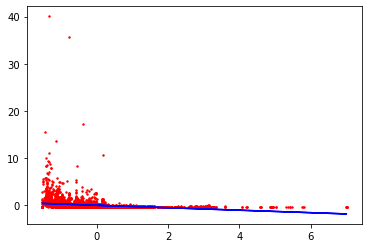

In [28]:
# Train the model
reg_model.fit(x1["distance"].values.reshape(-1, 1), y1.values.reshape(-1, 1))

# Test the model
y_pred = reg_model.predict(x2["distance"].values.reshape(-1, 1))
plt.scatter(x2["distance"], y2, s=2, color = 'red')
plt.plot(x2["distance"], reg_model.predict(x2["distance"].values.reshape(-1, 1)), color = 'blue')

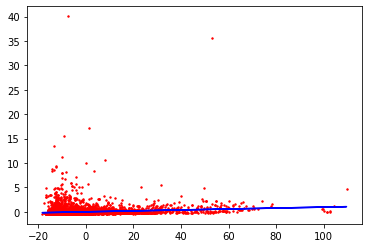

In [29]:
# Train the model
reg_model.fit(x1["principal 1"].values.reshape(-1, 1), y1.values.reshape(-1, 1))

# Test the model
y_pred = reg_model.predict(x2["principal 1"].values.reshape(-1, 1))
plt.scatter(x2["principal 1"], y2, s=2, color = 'red')
plt.plot(x2["principal 1"], reg_model.predict(x2["principal 1"].values.reshape(-1, 1)), color = 'blue')

In [30]:
x_test = x1.copy()
y_test = y1.copy()
x_train = x2.copy()
y_train = y2.copy()

pca_model = PCA(n_components=2)
reg_model = LinearRegression()

pca_train = pca_model.fit_transform(x_train, y_train)
pca_test = pca_model.fit_transform(x_test, y_test)

In [31]:
x_test.head()

,area_total,floor,rooms,stories,distance,principal 1,principal 2
14405,0.776341,6,3,7,-1.011612,-10.492800,-3.269573
19120,0.124746,1,3,14,-0.861646,-7.342527,4.733967
4734,-0.604230,11,2,12,-0.710831,-3.610154,-4.743232
2044,-0.638318,8,1,14,-0.927427,-3.565978,-1.135778
13171,0.034923,15,3,17,0.296430,2.767265,-5.396391


In [32]:
y_test.head()

,price
14405,0.418734
19120,-0.191950
4734,-0.276502
2044,-0.342987
13171,-0.172027


Text(0.5, 1.0, 'hp')

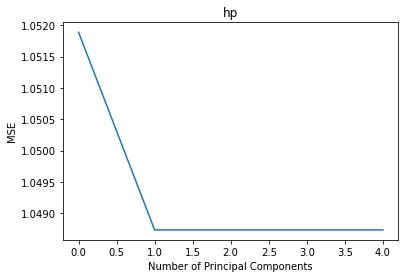

In [33]:
cv = RepeatedKFold(n_splits=7, n_repeats=5, random_state=1)
mse = []

for i in np.arange(1, 6):
    score = (-1 * model_selection.cross_val_score(reg_model,
             pca_train[:,:i], y_train, cv=cv, 
             scoring='neg_mean_squared_error').mean())
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

In [34]:
np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=4)*100)

array([84.65, 99.21])

In [35]:
regMTrain = reg_model.fit(pca_train, y_train)
regMTest = reg_model.fit(pca_test, y_test)

In [36]:
y = regMTrain.predict(pca_test)

Text(0.5, 1.0, 'hp')

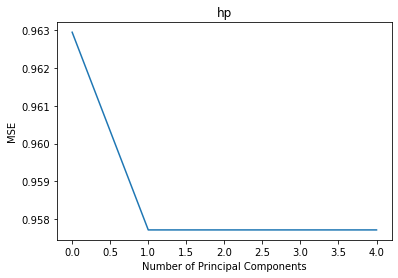

In [37]:
cv = RepeatedKFold(n_splits=7, n_repeats=5, random_state=1)
mse = []

for i in np.arange(1, 6):
    score = (-1 * model_selection.cross_val_score(reg_model,
             pca_test[:,:i], y_test, cv=cv, 
             scoring='neg_mean_squared_error').mean())
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')